In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [2]:
df=pd.read_csv('Concrete.csv')

# Data pre-processing

In [3]:
#rename the columns because the original column names are too long

df.rename(columns={'Cement (component 1)(kg in a m^3 mixture)': 'Cement', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)': 'Blast Furnace Slag'
                  ,'Fly Ash (component 3)(kg in a m^3 mixture)':'Fly Ash',
                   'Water  (component 4)(kg in a m^3 mixture)':'Water',
                   'Superplasticizer (component 5)(kg in a m^3 mixture)':'Superplasticizer'
                   ,'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':'Coarse Aggregate'
                  ,'Fine Aggregate (component 7)(kg in a m^3 mixture)':'Fine Aggregate','Age (day)':'Age'
                   ,'Concrete compressive strength(MPa, megapascals) ':'Concrete compressive strength'}, 
          inplace=True)

In [4]:
# No null value exist in the dataframe
df.isnull().values.any()

False

In [5]:
#check the skewness of each predictors
df.skew()

Cement                           0.509517
Blast Furnace Slag               0.800737
Fly Ash                          0.537445
Water                            0.074324
Superplasticizer                 0.908113
Coarse Aggregate                -0.040206
Fine Aggregate                  -0.252979
Age                              3.269177
Concrete compressive strength    0.416922
dtype: float64

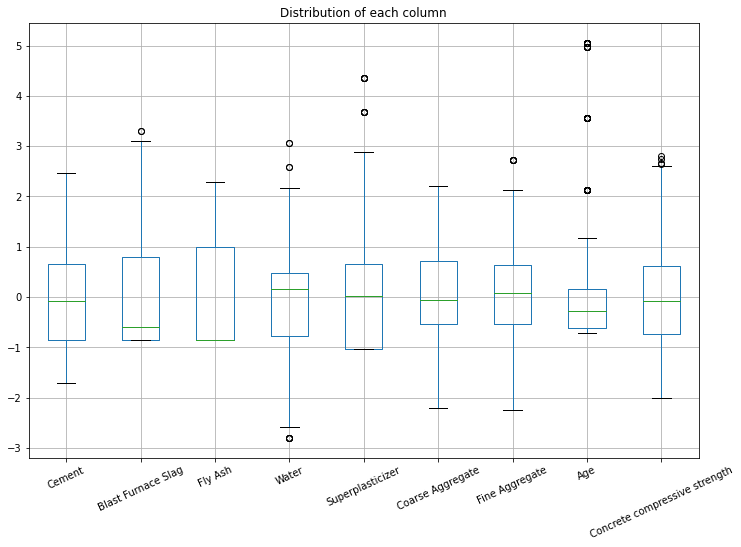

In [6]:
#Normalization and check whether outliers exist or not
#The normalized data is just for demonstration
# Data used in model training won't be normalized
normalized_df=(df.copy()-df.mean())/df.std()
normalized_df.boxplot();
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.xticks(rotation=25);
plt.title('Distribution of each column',fontsize=12);


In [7]:
#Split the datafarme into test set and training set
X=df.iloc[:,:-1].copy()
y=df.iloc[:,-1].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

# we reserve the dataset in order to compare the performance of model(model with outliers vs. model without outliers) 
#and then decide we should remove the outliers or not

df_reserved=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
#49 rows are dropped, outliers are removed from the dataframe
X2=df_reserved.iloc[:,:-1].copy()
y2=df_reserved.iloc[:,-1].copy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20) 

In [8]:
#we use the performance of OLS to decide whether we should drop the outliers or not
#and cross validation is used

model=LinearRegression()
kfold = KFold(n_splits=5)
cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cv_results2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
original_MSE=round(np.absolute(cv_results.mean()),3)
original_R2=round(np.absolute(cv_results2.mean()),3)

In [9]:
cv_results = cross_val_score(model, X_train2, y_train2, cv=kfold, scoring='neg_mean_squared_error')
cv_results2 = cross_val_score(model, X_train2, y_train2, cv=kfold, scoring='r2')
drop_MSE=round(np.absolute(cv_results.mean()),3)
drop_R2=round(np.absolute(cv_results2.mean()),3)

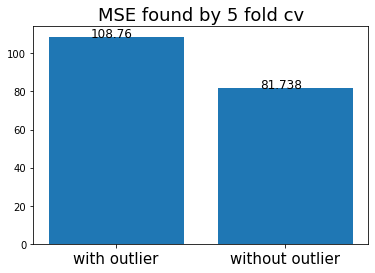

In [10]:
bar1=plt.bar(x=['with outlier','without outlier'],height=[original_MSE,drop_MSE]);
plt.xticks(fontsize=15);
plt.title('MSE found by 5 fold cv',fontsize=18);
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.25, yval +0.01, round(yval,3),fontsize=12)
#It is found that OLS without outliers has a lower MSE

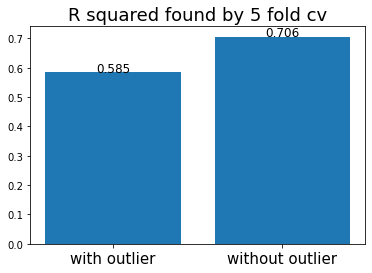

In [11]:
bar2=plt.bar(x=['with outlier','without outlier'],height=[original_R2,drop_R2]);
plt.xticks(fontsize=15);
plt.title('R squared found by 5 fold cv',fontsize=18);
for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.3, yval +0.001, round(yval,3),fontsize=12)

In [12]:
#from the bar chart above, we should drop the outliers

df=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
X=df.iloc[:,:-1].copy()
y=df.iloc[:,-1].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

# Check the necessary of subset selection

In [13]:
from statsmodels.api import OLS
import statsmodels.api as sm
model_reg=OLS(y_train,sm.add_constant(X_train)).fit()
model_reg.summary()
# The focus is the coefficients of the predictors
#because all the predictors' P value are < 0.05, therefore no predictors need to be removed

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Concrete compressive strength   R-squared:                       0.722
Model:                                       OLS   Adj. R-squared:                  0.719
Method:                            Least Squares   F-statistic:                     251.6
Date:                           Tue, 05 Apr 2022   Prob (F-statistic):          1.42e-209
Time:                                   22:00:18   Log-Likelihood:                -2820.3
No. Observations:                            784   AIC:                             5659.
Df Residuals:                                775   BIC:                             5701.
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -20.3954     26.638     -0.766      0.444     -72.686      31.895
Cement                 0.1175      0.008     13.994      0.000       0.101       0.134
Blast Furnace Slag     0.1022      0.010      9.931      0.000       0.082       0.122
Fly Ash                0.0750      0.013      5.898      0.000       0.050       0.100
Water                 -0.1464      0.040     -3.644      0.000      -0.225      -0.068
Superplasticizer       0.4146      0.102      4.069      0.000       0.215       0.615
Coarse Aggregate       0.0123      0.009      1.293      0.196      -0.006       0.031
Fine Aggregate         0.0191      0.011      1.784      0.075      -0.002       0.040
Age                    0.2345      0.009     26.147      0.000       0.217       0.252
==============================================================================
Omnibus:                       17.783   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.274
Skew:                          -0.162   Prob(JB):                     4.40e-07
Kurtosis:                       3.890   Cond. No.                     1.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Correlation and check multicollinearty

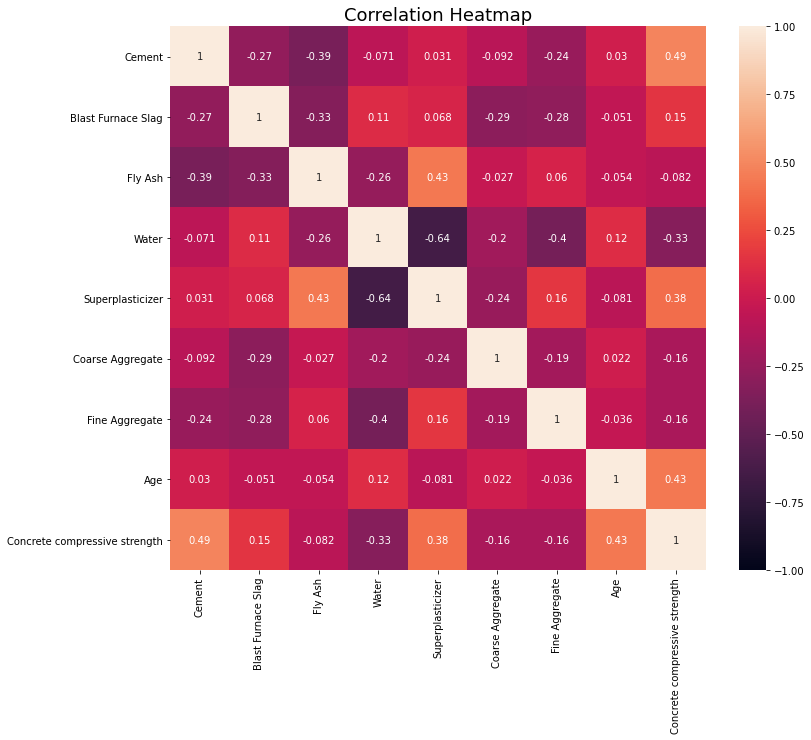

In [14]:
# check the correlation between predictors
model_reg.params=model_reg.params[1:]
fig = sm.graphics.plot_regress_exog(model_reg, 'Age', fig=fig)
plt.figure(figsize=(12, 10));
hm=sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True);
hm.set_title('Correlation Heatmap', fontdict={'fontsize':18});


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
x_temp = sm.add_constant(X_train)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

#we can see that VIF of several columns > 5, it indicates multicolinear relationship exist

   VIF Factor            features
0      7049.8               const
1         7.1              Cement
2         7.8  Blast Furnace Slag
3         6.7             Fly Ash
4         6.5               Water
5         3.1    Superplasticizer
6         5.3    Coarse Aggregate
7         6.8      Fine Aggregate
8         1.0                 Age


## tried to drop a column from data 

In [16]:
#we try to drop one column, then check whether multicolinearity disappear
df_check=df.copy()
df_check.drop(['Blast Furnace Slag'],inplace=True,axis=1)
X3=df_check.iloc[:,:-1].copy()
y3=df_check.iloc[:,-1].copy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.20) 

In [17]:
model = sm.OLS(y_train3, sm.add_constant(X_train3)).fit()
Y_pred3 = model.predict(sm.add_constant(X_test3))
print_model = model.summary()
x_temp3 = sm.add_constant(X_train3)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp3.values, i) for i in range(x_temp3.values.shape[1])]
vif["features"] = x_temp3.columns
print(vif.round(1))


   VIF Factor          features
0      1816.4             const
1         1.5            Cement
2         1.6           Fly Ash
3         3.5             Water
4         2.9  Superplasticizer
5         1.8  Coarse Aggregate
6         1.8    Fine Aggregate
7         1.0               Age


In [18]:
model=LinearRegression()
kfold = KFold(n_splits=5)
cv_results = cross_val_score(model, X_train3, y_train3, cv=kfold, scoring='neg_mean_squared_error')
cv_results2 = cross_val_score(model, X_train3, y_train3, cv=kfold, scoring='r2')
msg = " MSE:%f (std:%f) R-squared:%f" % (np.absolute(cv_results.mean()), cv_results.std(),np.absolute(cv_results2.mean()))
original_MSE=round(np.absolute(cv_results.mean()),3)
original_R2=round(np.absolute(cv_results2.mean()),3)
print(msg)

#The MSE increased and R2 decreased
#It indicates the predictability of model is weaken, therefore we should keep the column and neglect the multicolinearity

 MSE:91.697446 (std:11.419182) R-squared:0.656796


# Cross validation for model selection

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline

In [20]:
#Check the performance of different regression model
models = [('Linear Regression',LinearRegression()),('LASSO', Lasso()),('Ridge',Ridge()),('EN', ElasticNet()),
          ('KNN', KNeighborsRegressor()),('CART', DecisionTreeRegressor()),('GBM', GradientBoostingRegressor())
         ,('ExtraTree',ExtraTreesRegressor()),('XGBoost',xgb.XGBRegressor())]
names = list()
Model_MSE=list()
Model_R2=list()
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_results2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    names.append(name)
    msg = "%s: MSE:%f (std:%f) R-squared:%f" % (name, np.absolute(cv_results.mean()), cv_results.std(),np.absolute(cv_results2.mean()))
    print(msg)
    Model_MSE.append(np.absolute(cv_results.mean()))
    Model_R2.append(np.absolute(cv_results2.mean()))

Linear Regression: MSE:80.214668 (std:8.976467) R-squared:0.709030
LASSO: MSE:80.276798 (std:9.343528) R-squared:0.708817
Ridge: MSE:80.214614 (std:8.976736) R-squared:0.709030
EN: MSE:80.225497 (std:9.237614) R-squared:0.708996
KNN: MSE:87.658586 (std:11.624748) R-squared:0.684148
CART: MSE:43.618685 (std:12.101052) R-squared:0.849366
GBM: MSE:26.554165 (std:6.066897) R-squared:0.905044
ExtraTree: MSE:23.870888 (std:8.415196) R-squared:0.913807
XGBoost: MSE:21.242501 (std:6.567169) R-squared:0.923122


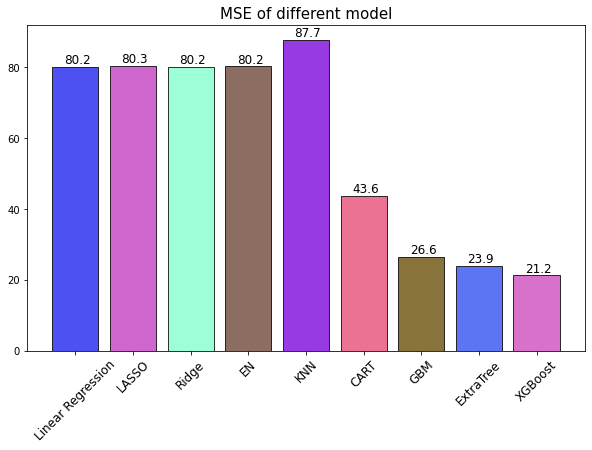

In [21]:
import random
rand_color=list()
for color in range(10):
    color=(random.random(),random.random(),random.random())
    rand_color.append(color)

bars = plt.bar(names, height=Model_MSE, width=0.8,color=rand_color,alpha=0.8,edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval+1 , round(yval,1),fontsize=12)
plt.title('MSE of different model',fontsize=15);
fig=plt.gcf()
fig.set_size_inches(10,6);
plt.xticks(rotation=45,fontsize=12);

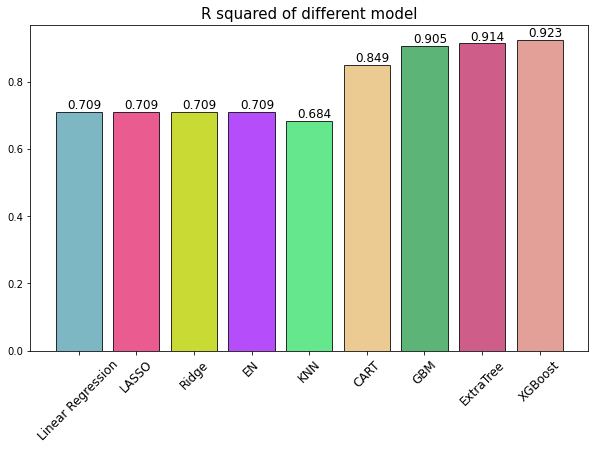

In [22]:
rand_color=list()
for color in range(10):
    color=(random.random(),random.random(),random.random())
    rand_color.append(color)

bars = plt.bar(names, height=Model_R2, width=0.8,color=rand_color,alpha=0.8,edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval +0.01, round(yval,3),fontsize=12)
plt.title('R squared of different model',fontsize=15);
fig=plt.gcf()
fig.set_size_inches(10,6);
plt.xticks(rotation=45,fontsize=12);

# Polynomial regression for checking the flexibility of model needed

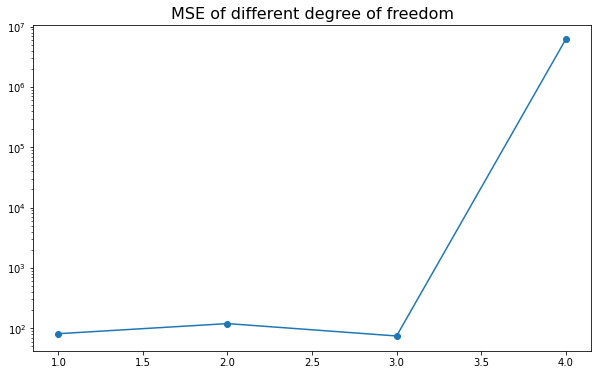

In [23]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train)
X_poly_test = poly_reg.fit_transform(X_test)
pol_reg = LinearRegression()
model_trained=pol_reg.fit(X_poly, y_train)
poly_predict=model_trained.predict(X_poly_test)
MSE=np.mean((poly_predict-y_test)**2)
R2_list=list()
MSE_list=list()
for i in range(1,5):
    kfold = KFold(n_splits=5)
    poly_deg=PolynomialFeatures(degree=i)
    X_poly = poly_deg.fit_transform(X_train)
    pol_reg = LinearRegression()
    cv_results = cross_val_score(pol_reg, X_poly, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_results2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    R2_list.append(np.absolute(cv_results2.mean()))
    MSE_list.append(np.absolute(cv_results.mean()))
    names.append(name)
    X_poly_test = poly_deg.fit_transform(X_test)
    model_trained=pol_reg.fit(X_poly, y_train)
    poly_predict=model_trained.predict(X_poly_test)
plt.plot(range(1,5),MSE_list,'-o');
plt.title('MSE of different degree of freedom',fontsize=16);
ax = plt.gca()
ax.set_yscale("log")
fig=plt.gcf()
fig.set_size_inches(10,6);

### from the graph below, we can see the degree of original function should be 3 
### it indicates more flexible model is needed
### Thus Gradient Boosting Regressor,Extra Trees Regressor,XGBooster regressor are choosen 

# Hyperparameter tuning

In [24]:
from sklearn.model_selection import GridSearchCV
GBR=GradientBoostingRegressor()
grid_params = {
    'n_estimators': [90, 100, 120, 180, 200],
    'learning_rate' : [0.01, 0.1, 0.05, 0.5, 1],
    'loss' : ['ls', 'lad', 'huber', 'quantile']
}
grid_search = GridSearchCV(GBR, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)
print('Best parameters:',grid_search.best_params_)
print('Best score:',grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\USER\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 200}
Best score: 0.9162569104291975


In [25]:
kwargs=grid_search.best_params_
GBR=GradientBoostingRegressor(**kwargs)
model_GBR=GBR.fit(X_train,y_train)
prediction=model_GBR.predict(X_test)
GBR_Test_MSE=round(np.mean((prediction-y_test)**2),3)
GBR_prediction=prediction
GBR_R2=GBR.score(X_test, y_test)

C:\Users\USER\anaconda\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


In [26]:
model = ExtraTreesRegressor()
grid_params = {
     'n_estimators': [10,50,100],'criterion': ['mse'],'max_depth': [2,8,16,32,50],'min_samples_split': [2,4,6,8],'min_samples_leaf': [1,2,3,4,5],'max_features': ['auto'],    
    'bootstrap': [True, False],'warm_start': [True, False],       }
grid_search = GridSearchCV(model, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)
print('Best parameter:',grid_search.best_params_)
print('Best score:',grid_search.best_score_)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


C:\Users\USER\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


Best parameter: {'bootstrap': False, 'criterion': 'mse', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'warm_start': False}
Best score: 0.9107996330953532


In [27]:
model = ExtraTreesRegressor(**grid_search.best_params_)
model_ExtraTree=model.fit(X_train,y_train)
prediction=model.predict(X_test)
Extra_Tree_Test_MSE=round(np.mean((prediction-y_test)**2),3)
ExtraTree_R2=model.score(X_test, y_test)

C:\Users\USER\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


In [28]:
XGB=xgb.XGBRegressor()
model_XGB=XGB.fit(X_train,y_train)
prediction=model_XGB.predict(X_test)
XGB_Test_MSE=round(np.mean((prediction-y_test)**2),3)
XGB_R2=XGB.score(X_test, y_test)

# Test result 

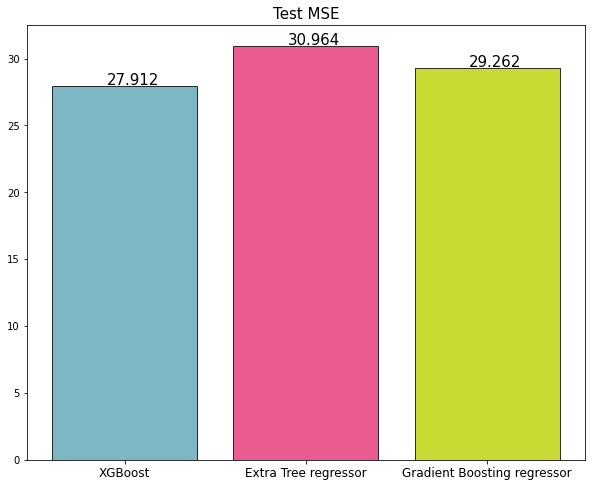

In [29]:
#after hyperparameter tunning, these models are used to predict the test set
final=[XGB_Test_MSE,Extra_Tree_Test_MSE,GBR_Test_MSE]
name_final=['XGBoost','Extra Tree regressor','Gradient Boosting regressor']
final_R2=[XGB_R2,ExtraTree_R2,GBR_R2]
bars=plt.bar(name_final,final,color=rand_color,alpha=0.8,edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.3, yval+0.1 , round(yval,3),fontsize=15)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xticks(fontsize=12);
plt.title('Test MSE',fontsize=15);

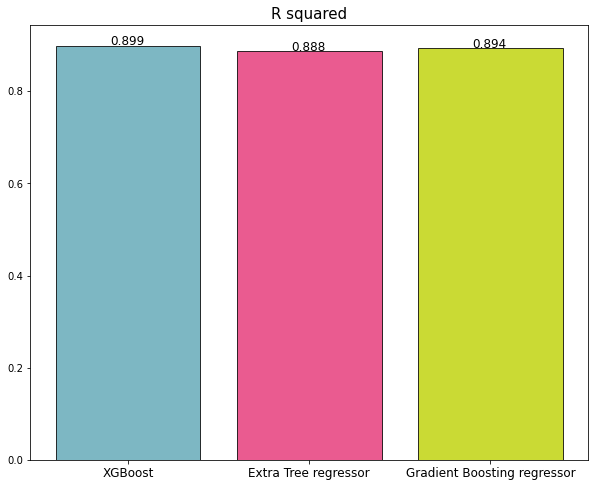

In [30]:
bars2=plt.bar(name_final,final_R2,color=rand_color,alpha=0.8,edgecolor='black')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.3, yval+0.001 , round(yval,3),fontsize=12)
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xticks(fontsize=12);
plt.title('R squared',fontsize=15);

### Conclusion: XGBoost has the best performance